In [2]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
import numpy as np

In [3]:
credits = pd.read_csv('the-movies-dataset/credits.csv')
keywords = pd.read_csv('the-movies-dataset/keywords.csv')
movies = pd.read_csv('the-movies-dataset/movies_metadata.csv', low_memory=False).\
    drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1)

movies['id'] = movies['id'].apply(pd.to_numeric, errors='coerce')
movies.dropna(inplace=True)
movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [4]:
def get_text(text, obj='name'):
    text = eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [8]:
ratings_df = pd.read_csv('the-movies-dataset/ratings.csv')
ratings_df.sample(5)

ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)
ratings_df.sample(5)

,userId,movieId,rating,date,original_title,genres,overview
7319605,255258,239,3.0,1998-08-11 10:49:38,Some Like It Hot,"Comedy, Romance",Two musicians witness a mob hit and struggle t...
2969048,103067,1247,4.0,2002-11-27 15:47:36,The Good Shepherd,"Drama, Thriller, History","Edward Wilson, the only witness to his father'..."
1368656,47391,1374,4.0,2017-04-05 16:16:23,Rocky IV,Drama,Rocky must come out of retirement to battle a ...
6321166,220308,497,3.0,2002-07-21 07:00:41,The Green Mile,"Fantasy, Drama, Crime",A supernatural tale set on death row in a Sout...
6332127,220695,2059,4.0,2000-11-28 00:20:20,National Treasure,"Adventure, Action, Thriller, Mystery","Modern treasure hunters, led by archaeologist ..."


In [9]:
movies_df = df.loc[:, ['id', 'original_title', 'genres', 'overview', 'production_companies', 'actors']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.sample(5)

,movieId,original_title,genres,overview,production_companies,actors
1993,48259,Crimes of the Heart,"Drama, Family",Three sisters with quite different personaliti...,"De Laurentiis Entertainment Group (DEG), De La...","Diane Keaton, Jessica Lange, Sissy Spacek, Sam..."
12273,146239,Delivery Man,Comedy,An affable underachiever finds out he's father...,"DreamWorks SKG, Touchstone Pictures","Vince Vaughn, Cobie Smulders, Chris Pratt, Bri..."
2187,46286,The Suburbans,"Comedy, Drama",An 80s one-hit wonder band named The Suburbans...,"Ignite Entertainment, HSX Films, Motion Pictur...","Jennifer Love Hewitt, Bridgette Wilson, Craig ..."
12072,114726,Out on a Limb,Comedy,"While heading to the town where his sister, Ma...",Universal Pictures,"Matthew Broderick, Jeffrey Jones, Heidi Kling,..."
2366,10326,Forever Young,"Adventure, Fantasy, Drama, Science Fiction, Ro...",A 1939 test pilot asks his best friend to use ...,"Icon Entertainment International, Warner Bros.","Mel Gibson, Jamie Lee Curtis, Elijah Wood, Isa..."


In [15]:
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
mvoie_encoder = LabelEncoder()

ratings_df['userId'] = user_encoder.fit_transform(ratings_df['userId'])
ratings_df['movieId'] = mvoie_encoder.fit_transform(ratings_df['movieId'])

ratings_df

,userId,movieId,rating,date,original_title,genres,overview
0,0,82,4.5,2015-03-09 18:07:15,Les Quatre Cents Coups,Drama,"For young Parisian boy Antoine Doinel, life is..."
1,0,528,5.0,2015-03-09 17:52:03,Sleepless in Seattle,"Comedy, Drama, Romance",A young boy who tries to set his dad up on a d...
2,0,637,5.0,2015-03-09 17:52:36,Rocky Balboa,Drama,When he loses a highly publicized virtual boxi...
3,0,905,4.0,2015-03-09 18:02:28,Fools Rush In,"Drama, Comedy, Romance",Alex Whitman (Matthew Perry) is a designer fro...
4,0,1140,4.5,2015-03-09 17:48:20,Young and Innocent,"Drama, Crime",Derrick De Marney finds himself in a 39 Steps ...
...,...,...,...,...,...,...,...
7754667,261011,2504,5.0,2009-10-31 18:25:46,Loose Screws,Comedy,"Brad, Steve, Hue, and Marvin are four get-nowh..."
7754668,261011,2532,3.5,2009-10-31 18:28:35,No mires para abajo,"Drama, Romance",A sexy Spanish siren named Elvira schools a yo...
7754669,261011,2542,4.5,2009-10-31 19:07:17,The Great American Girl Robbery,"Comedy, Crime",A busload containing three cheerleading teams ...
7754670,261011,2580,4.0,2009-10-31 18:32:19,Indestructible Man,"Crime, Horror, Science Fiction",Scientific experiments accidentally revive an ...


In [16]:
min_movie_ratings = 10000
filter_movies = (ratings_df.groupby('movieId')['rating'].sum()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

min_user_ratings = 200
filter_users = (ratings_df.groupby('userId')['rating'].sum()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

df_filterd = ratings_df[(ratings_df['movieId'].isin(filter_movies)) & (ratings_df['userId'].isin(filter_users))]

print('Shape User-Ratings unfiltered:\t{}'.format(ratings_df.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filterd.shape))

Shape User-Ratings unfiltered:	(7754672, 7)
Shape User-Ratings filtered:	(3788984, 7)


In [17]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_filterd, test_size=0.3)
train_df.shape, test_df.shape

((2652288, 7), (1136696, 7))

In [18]:
def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    from keras.layers import Input, Embedding, Dense, Dropout, Flatten, Dot
    from keras.models import Model

    movie_input = Input(shape=(1,), name='movie_id')

    movie_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = Flatten(name='FlattenMovie')(movie_emb)

    movie_model = Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = Input(shape=(1,), name='user_id')

    user_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = Flatten(name='FlattenUser')(user_emb)

    user_model = Model(inputs=user_input, outputs=user_vec)
    
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    merged = Dropout(0.2)(merged)
    
    
    dense_1 = Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = Dense(1, name='result', activation="relu") (dense_4)
    model = Model([movie_input, user_input], result)
    model.compile(loss='mse', optimizer='adam')
    return model, movie_model, user_model

In [19]:
ROW_COUNT = train_df.shape[0]
EMBEDDING_SIZE = 10
NUM_USERS = ratings_df['userId'].nunique()
NUM_MOVIES = ratings_df['movieId'].nunique()
UNIQUE_MOVIE_IDS = ratings_df['movieId'].unique()
MOVIE_METADATA = ratings_df.groupby('movieId', as_index=False)[['original_title', 'genres', 'overview']].first()

NUM_USERS, NUM_MOVIES, ROW_COUNT

(261012, 3761, 2652288)

In [20]:
model, movie_model, user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)

In [21]:
train_df['movieId'].shape, train_df['userId'].shape,train_df['rating'].shape

((2652288,), (2652288,), (2652288,))

In [22]:
test_df['movieId'].shape, test_df['userId'].shape,test_df['rating'].shape


((1136696,), (1136696,), (1136696,))

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [EarlyStopping('val_loss', patience=10),
             ModelCheckpoint('besttest.h5', save_best_only=True)]

history = model.fit([train_df['movieId'], train_df['userId']],
          train_df['rating'],
          batch_size=256, 
          epochs=1,
          validation_split=0.1,
          shuffle=True,
          callbacks = callbacks)

9325/9325 [==============================] - 239s 25ms/step - loss: 1.1106 - val_loss: 1.0442


In [24]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict([test_df['movieId'], test_df['userId']]).reshape(-1)
y_true = test_df['rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Matrix-Factorization: {:.4f} RMSE'.format(rmse))

35522/35522 [==============================] - 29s 761us/step


Testing Result With Keras Matrix-Factorization: 1.0208 RMSE


In [25]:
tags = [i.split(", ") for i in df['genres'].unique()]
genres = list(set([i for lst in tags for i in lst]))
genres.remove('')
print(genres)

['Drama', 'Crime', 'Thriller', 'Science Fiction', 'War', 'Foreign', 'Music', 'Mystery', 'Comedy', 'Fantasy', 'Adventure', 'Western', 'Family', 'Romance', 'Animation', 'Documentary', 'History', 'Horror', 'Action', 'TV Movie']


In [31]:
for col in genres:
    train_df[col] = train_df["genres"].apply(lambda x: 1 if col in x else 0)
    test_df[col] = test_df["genres"].apply(lambda x: 1 if col in x else 0)
test_df.head()


,userId,movieId,rating,date,original_title,genres,overview,Drama,Crime,Thriller,...,Adventure,Western,Family,Romance,Animation,Documentary,History,Horror,Action,TV Movie
3416451,114708,674,2.5,2005-11-15 20:53:21,Y tu mamá también,"Drama, Romance","In Mexico, two teenage boys and an attractive ...",1,0,0,...,0,0,0,1,0,0,0,0,0,0
2848241,95238,317,2.5,2007-01-11 13:58:37,The Poseidon Adventure,"Action, Adventure",The Poseidon Adventure was one of the first Ca...,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2139225,71552,1053,3.5,2013-09-20 15:02:27,Prime,"Comedy, Drama, Romance",A career driven professional from Manhattan is...,1,0,0,...,0,0,0,1,0,0,0,0,0,0
978457,32808,1923,4.5,2007-10-16 16:55:16,Bad Boys II,"Adventure, Action, Comedy, Thriller, Crime","Out-of-control, trash-talking buddy cops Marcu...",0,1,1,...,1,0,0,0,0,0,0,0,1,0
1134020,38220,1072,4.0,2000-11-20 21:00:26,The Nativity Story,"Drama, History",Mary and Joseph make the hard journey to Bethl...,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [32]:
def get_model3(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT, NUM_GENRES):
    from keras.layers import Input, Embedding, Dense, Dropout, Flatten, Dot, Reshape, Concatenate
    from keras.models import Model

    movie_input = Input(shape=(1,), name='movie_id')

    movie_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)

    movie_res = Reshape(target_shape=(EMBEDDING_SIZE,), name='movie_res')(movie_emb)

    user_input = Input(shape=(1,), name='user_id')

    user_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)

    user_res = Reshape(target_shape=(EMBEDDING_SIZE,), name='user_res')(user_emb)
    
    merged = Dot(name = 'dot_product', normalize = True, axes = 1)([movie_res, user_res])

    #############################
    genres_input = Input(shape=(NUM_GENRES,),name='genres')
    dense_gen_1 = Dense(70,name='FullyConnected-gen_1')(genres_input)
    dropout_gen_1 = Dropout(0.2,name='Dropout_gen_1')(dense_gen_1)

    dense_gen_2 = Dense(50,name='FullyConnected-gen_2')(dropout_gen_1)
    dropout_gen_2 = Dropout(0.2,name='Dropout_gen_2')(dense_gen_2)

    dense_gen_3 = Dense(20,name='FullyConnected-gen_3')(dropout_gen_2)
    dropout_gen_3 = Dropout(0.2,name='Dropout_gen_3')(dense_gen_3)

    dense_gen_4 = Dense(10,name='FullyConnected-gen_4', activation='relu')(dropout_gen_3)
    #############################

    merged = Dropout(0.2)(merged)
    
    dense_1 = Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    concat = Concatenate()([dense_4, dense_gen_4])

    result = Dense(1, name='result', activation="relu") (concat)
    model = Model([movie_input, user_input, genres_input], result)
    model.compile(loss='mse', optimizer='adam')
    return model

In [33]:
model = get_model3(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT, len(genres))

In [42]:
history = model.fit([train_df['movieId'], train_df['userId'], train_df[genres]],
          train_df['rating'],
          batch_size=2048, 
          epochs=20,
          validation_split=0.1,
          shuffle=True,
          callbacks = callbacks)

Epoch 1/20
1166/1166 [==============================] - 27s 23ms/step - loss: 0.7099 - val_loss: 0.6958
Epoch 2/20
1166/1166 [==============================] - 27s 23ms/step - loss: 0.6956 - val_loss: 0.6908
Epoch 3/20
1166/1166 [==============================] - 27s 23ms/step - loss: 0.6838 - val_loss: 0.6833
Epoch 4/20
1166/1166 [==============================] - 27s 23ms/step - loss: 0.6742 - val_loss: 0.6799
Epoch 5/20
1166/1166 [==============================] - 27s 23ms/step - loss: 0.6664 - val_loss: 0.6809
Epoch 6/20
1166/1166 [==============================] - 27s 23ms/step - loss: 0.6580 - val_loss: 0.6722
Epoch 7/20
1166/1166 [==============================] - 27s 23ms/step - loss: 0.6520 - val_loss: 0.6728
Epoch 8/20
1166/1166 [==============================] - 27s 23ms/step - loss: 0.6464 - val_loss: 0.6735
Epoch 9/20
1166/1166 [==============================] - 27s 23ms/step - loss: 0.6431 - val_loss: 0.6706
Epoch 10/20
1166/1166 [==============================] - 27s 23m

In [43]:
y_pred = model.predict([test_df['movieId'], test_df['userId'], test_df[genres]]).reshape(-1)
y_true = test_df['rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Matrix-Factorization: {:.4f} RMSE'.format(rmse))

35522/35522 [==============================] - 26s 741us/step


Testing Result With Keras Matrix-Factorization: 0.8178 RMSE


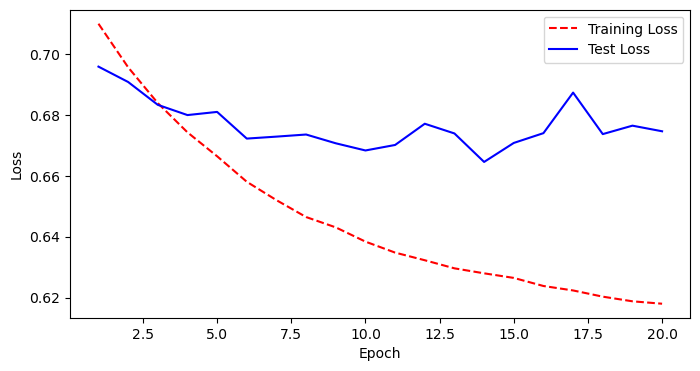

In [44]:
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [45]:
history.history

{'loss': [0.709877073764801,
  0.6955849528312683,
  0.6838382482528687,
  0.674242377281189,
  0.6663885116577148,
  0.6580197811126709,
  0.6519889235496521,
  0.6464462876319885,
  0.6430538296699524,
  0.6383817791938782,
  0.6347801089286804,
  0.632273256778717,
  0.6296160817146301,
  0.6279804706573486,
  0.6264751553535461,
  0.6238222718238831,
  0.6223601698875427,
  0.6203246712684631,
  0.6188003420829773,
  0.6180064082145691],
 'val_loss': [0.6958000063896179,
  0.6907616853713989,
  0.6832627654075623,
  0.6799049973487854,
  0.6809407472610474,
  0.6721892952919006,
  0.6728336811065674,
  0.6735239624977112,
  0.670644998550415,
  0.668290913105011,
  0.6700955033302307,
  0.6770602464675903,
  0.6738758683204651,
  0.6645272970199585,
  0.6707594990730286,
  0.6739724278450012,
  0.6872751116752625,
  0.6736602783203125,
  0.6764302849769592,
  0.6745872497558594]}